#### 1. Load the data

In [1]:
import pandas as pd
import os

os.chdir('D://Analytics/Kaggle/toxic_comment_challenge/')
print(os.getcwd())

dev = pd.read_csv('data/raw/train.csv')
val = pd.read_csv('data/raw/test.csv')
print(dev.shape)
print(val.shape)

D:\Analytics\Kaggle\toxic_comment_challenge
(95851, 8)
(226998, 2)


In [2]:
# Identifying the target columns
y_cols = [c for c in dev.columns if c not in ['id','comment_text']]
y_vals = dev[y_cols].as_matrix()

# Flagging the validation ids
vid = val['id'].values

# Number of rows in the dev sample
nrows = dev.shape[0]

print(dev[y_cols].sum())

toxic            9237
severe_toxic      965
obscene          5109
threat            305
insult           4765
identity_hate     814
dtype: int64


#### 2. EDA

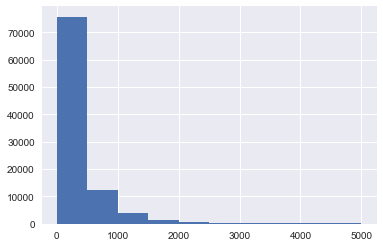

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Getting the length of each comment in the dev sample
dev['char_length'] = dev['comment_text'].str.len()

# Visualizing the distribution
sns.set()
dev['char_length'].hist()
plt.show()

In the dev sample, most of the comments are 1000 characters or under. The maximum comment length is 5000 characters.

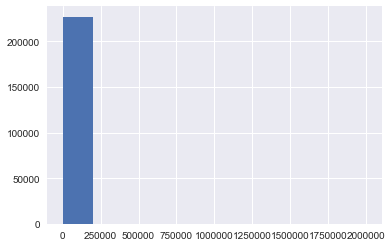

In [6]:
# Getting the length of each comment in the val sample
val['char_length'] = val['comment_text'].str.len()

# Visualizing the distribution
sns.set()
val['char_length'].hist()
plt.show()

The validation sample has comments with a lot more characters. Probably, the comments in the dev sample were truncated to 5000 characters. So, we'll do the same for the validation sample.

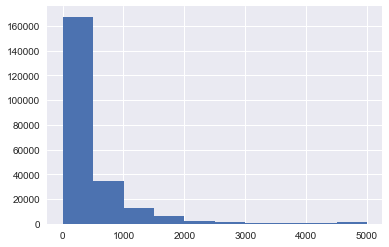

In [8]:
# Truncate the validation sample to max length of 5000 characters to match the dev sample
val = val.fillna("unknown")
val['comment_text'] = val['comment_text'].apply(lambda x: x[:5000])
val['char_length'] = val['comment_text'].str.len()

# Visualizing the distribution
sns.set()
val['char_length'].hist()
plt.show()

Now we can see the distribution of comment length are roughly the same between the development and validation samples.

#### 3. Data prep

In [27]:
# Concatenating the dev and val datasets
df_txt = pd.concat([dev['comment_text'], val['comment_text']], axis=0)
print(df_txt.shape)

(322849,)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the text to Tfidf format
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1,4), max_features=50000, min_df=3)
data = tfidf.fit_transform(df_txt)
print(data.shape)

(322849, 50000)


In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[:nrows], y_vals, test_size=.3, random_state=52)

#### 4. Train the models

We will use a prediction chaining technique, where we feed the prior model's predictions into the current model. For example, we take the predictions for the toxic comments and feed them into the severe toxic model. Toxic comments are highly correlated with severe toxic, so by chaining the predictions it may help to better differentiate between these two types of comments.

In [26]:
from xgboost import XGBClassifier
import numpy as np
from scipy.sparse import csr_matrix, hstack

preds = np.zeros((val.shape[0], len(y_cols)))

x_val = data[nrows:]

for i, c in enumerate(y_cols):
    print('Fitting %s' % c)
    
    # Initialize the model parameters
    xgb = XGBClassifier(learning_rate=0.1,
                        max_depth=3,
                        n_estimators=6000,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        n_jobs=-1
                        )

    # Train the model
    xgb.fit(x_train,
            y_train[:,i],
            verbose=10,
            early_stopping_rounds=50,
            eval_set=[(x_train, y_train[:,i]), (x_test, y_test[:,i])]
            )
    
    # Best iteration
    num_trees = xgb.get_booster().best_iteration
    
    # Predictions on training
    y_train_prob = xgb.predict_proba(x_train, ntree_limit=num_trees)[:,1]
    
    # Predictions on test
    y_test_prob = xgb.predict_proba(x_test, ntree_limit=num_trees)[:,1]
    
    # Predictions on validation
    y_val_prob = xgb.predict_proba(x_val, ntree_limit=num_trees)[:,1]
    
    # Append final predictions
    preds[:,i] = y_val_prob
    
    # Reshape training
    x_train = hstack([csr_matrix(y_train_prob).T, x_train])
    
    # Reshape test
    x_test = hstack([csr_matrix(y_test_prob).T, x_test])
    
    # Reshape val
    x_val = hstack([csr_matrix(y_val_prob).T, x_val])

Fitting toxic
[0]	validation_0-logloss:0.620265	validation_1-logloss:0.620885
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[10]	validation_0-logloss:0.304907	validation_1-logloss:0.309751
[20]	validation_0-logloss:0.224344	validation_1-logloss:0.231468
[30]	validation_0-logloss:0.194366	validation_1-logloss:0.202579
[40]	validation_0-logloss:0.178089	validation_1-logloss:0.18756
[50]	validation_0-logloss:0.167586	validation_1-logloss:0.177914
[60]	validation_0-logloss:0.159217	validation_1-logloss:0.17049
[70]	validation_0-logloss:0.152554	validation_1-logloss:0.164971
[80]	validation_0-logloss:0.1469	validation_1-logloss:0.160301
[90]	validation_0-logloss:0.142058	validation_1-logloss:0.156404
[100]	validation_0-logloss:0.137907	validation_1-logloss:0.153185
[110]	validation_0-logloss:0.13399	validation_1-logloss:0.15015
[120]	validation_0-logloss:0.130662	validation

[1220]	validation_0-logloss:0.049524	validation_1-logloss:0.110708
[1230]	validation_0-logloss:0.049235	validation_1-logloss:0.110697
[1240]	validation_0-logloss:0.048957	validation_1-logloss:0.110626
[1250]	validation_0-logloss:0.048689	validation_1-logloss:0.110604
[1260]	validation_0-logloss:0.048429	validation_1-logloss:0.110629
[1270]	validation_0-logloss:0.048163	validation_1-logloss:0.110663
[1280]	validation_0-logloss:0.047931	validation_1-logloss:0.110599
[1290]	validation_0-logloss:0.047651	validation_1-logloss:0.110551
[1300]	validation_0-logloss:0.047375	validation_1-logloss:0.110484
[1310]	validation_0-logloss:0.047141	validation_1-logloss:0.11048
[1320]	validation_0-logloss:0.046826	validation_1-logloss:0.110492
[1330]	validation_0-logloss:0.0466	validation_1-logloss:0.110456
[1340]	validation_0-logloss:0.046289	validation_1-logloss:0.110429
[1350]	validation_0-logloss:0.046045	validation_1-logloss:0.110412
[1360]	validation_0-logloss:0.04585	validation_1-logloss:0.110377

[110]	validation_0-logloss:0.051086	validation_1-logloss:0.069247
[120]	validation_0-logloss:0.050268	validation_1-logloss:0.069212
[130]	validation_0-logloss:0.04953	validation_1-logloss:0.069184
[140]	validation_0-logloss:0.04885	validation_1-logloss:0.069072
[150]	validation_0-logloss:0.048227	validation_1-logloss:0.06899
[160]	validation_0-logloss:0.047561	validation_1-logloss:0.069054
[170]	validation_0-logloss:0.046976	validation_1-logloss:0.069078
[180]	validation_0-logloss:0.046453	validation_1-logloss:0.069028
[190]	validation_0-logloss:0.045945	validation_1-logloss:0.069114
[200]	validation_0-logloss:0.045377	validation_1-logloss:0.06906
Stopping. Best iteration:
[151]	validation_0-logloss:0.048167	validation_1-logloss:0.06898

Fitting identity_hate
[0]	validation_0-logloss:0.600453	validation_1-logloss:0.600552
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[

#### 4. Create the submission files

In [28]:
submid = pd.DataFrame({'id': vid})
submission = pd.concat([submid, pd.DataFrame(preds, columns=y_cols)], axis=1)
submission.to_csv('data/submissions/xgb_chain.csv', index=False)
print(submission.shape)

(226998, 7)


In [29]:
sub1 = pd.read_csv('data/submissions/wtd_avg_3.csv')
sub3 = (sub1.as_matrix()[:,1:] * .1) + (submission.as_matrix()[:,1:] * .9)
sub3 = pd.concat([submid, pd.DataFrame(sub3, columns=y_cols)], axis=1)
sub3.to_csv('data/submissions/wtd_avg_4.csv', index=False)
print(sub3.shape)

(226998, 7)
